In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
import models
import generation_utils
import tokenizer
from data_utils import pad_input, dec2bin

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
t = tokenizer.Tokenizer()

In [5]:
device = torch.device('cuda')

In [6]:
checkpoint_path = '../models/pad_shared_gradnorm_10_layer/checkpoints/48_0.1046.pt'

In [7]:
checkpoint = torch.load(checkpoint_path)

In [8]:
args = checkpoint['args']

In [9]:
args.keys()

dict_keys(['data', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'verbose', 'tokenizer'])

In [10]:
model = models.Factorizer(n_tokens = args['tokenizer']['n_tokens'], 
                          max_decode_size = args['data']['max_decode_size'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Factorizer(
  (embedding): TransformerEmbedding(
    (embedding): Embedding(5, 64)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): 

In [11]:
example_row = generation_utils.factor(4489, model, t, device, args['data']['input_padding'], 
                        args['data']['max_input_size'], args['data']['max_decode_size'],
                       n_beams = 1)

In [15]:
example_row[['target_factor_list', 'pred_factor_list']]

,target_factor_list,pred_factor_list
0,"[67, 67]",[4489]


In [16]:
# input = t(example_row['target_str_full'].iloc[0].replace('_', '').replace('.', ''))

In [17]:
# input = t(example_row['target_str_full'].iloc[0])
input = t(dec2bin(example_row['target_num'].iloc[0]) + '.')
tgt = example_row['pred_str'].iloc[0]

In [18]:
input = torch.tensor(input).unsqueeze(0).to(device)
tgt = torch.tensor(t(tgt)).unsqueeze(0).to(device)

In [19]:
input.size(), tgt.size()

(torch.Size([1, 14]), torch.Size([1, 13]))

In [20]:
with torch.no_grad():
    memory, memory_key_padding_mask = model.encode(input)

In [21]:
memory.size(), memory_key_padding_mask.size()

(torch.Size([14, 1, 64]), torch.Size([1, 14]))

In [22]:
res = model.decode(tgt, memory.repeat(1, tgt.size(0), 1), memory_key_padding_mask.repeat(tgt.size(0), 1))

In [23]:
res

tensor([[[  5.0690,   5.0670,  -5.4712,  -9.0697, -10.6281],
         [  5.1683,   4.7493,  -4.2826,  -9.0565, -11.0973],
         [  5.8656,   3.6292,  -3.5206,  -8.5137, -11.7409],
         [  1.8033,   6.2217,  -4.4313,  -6.9404,  -9.4772],
         [ -1.1407,   4.8982,   2.1093,  -4.9132,  -8.8439],
         [  6.8491,   1.7024,  -4.0887,  -8.6976, -10.1006],
         [  8.7026,   0.1206,  -6.2498,  -9.3855,  -8.5815],
         [  8.4943,  -1.4520,  -5.2139,  -8.6120,  -8.7012],
         [ -3.1654,   9.0364,  -6.4208,  -6.0961,  -8.5070],
         [  8.2489,  -3.1730,  -5.1534,  -6.7028,  -6.2739],
         [  8.5632,  -1.5936,  -4.6962,  -7.9721,  -7.8439],
         [ -4.8896,   9.0051,  -7.5688,  -3.9345,  -5.4026],
         [ -3.4406,  -0.3837,  -2.0834,  14.3379,  -0.6054]]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [24]:
res2 = model.decode(tgt, memory.repeat(1, tgt.size(0), 1), memory_key_padding_mask.repeat(tgt.size(0), 1), return_enc_dec_attn=True)

In [25]:
res2[0]

tensor([[[  5.0690,   5.0670,  -5.4712,  -9.0697, -10.6281],
         [  5.1683,   4.7493,  -4.2826,  -9.0565, -11.0973],
         [  5.8656,   3.6292,  -3.5206,  -8.5137, -11.7409],
         [  1.8033,   6.2217,  -4.4313,  -6.9404,  -9.4772],
         [ -1.1407,   4.8982,   2.1093,  -4.9132,  -8.8439],
         [  6.8491,   1.7024,  -4.0887,  -8.6976, -10.1006],
         [  8.7026,   0.1206,  -6.2498,  -9.3855,  -8.5815],
         [  8.4943,  -1.4520,  -5.2139,  -8.6120,  -8.7012],
         [ -3.1654,   9.0364,  -6.4208,  -6.0961,  -8.5070],
         [  8.2489,  -3.1730,  -5.1534,  -6.7028,  -6.2739],
         [  8.5632,  -1.5936,  -4.6962,  -7.9721,  -7.8439],
         [ -4.8896,   9.0051,  -7.5688,  -3.9345,  -5.4026],
         [ -3.4406,  -0.3837,  -2.0834,  14.3379,  -0.6054]]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [26]:
attn_weights = res2[1]

In [27]:
attn_weights[0].size()

torch.Size([1, 13, 14])

In [28]:
attn_weights[-1]

tensor([[[0.0191, 0.2261, 0.2173, 0.1772, 0.0256, 0.0340, 0.0131, 0.0140,
          0.0124, 0.0337, 0.0339, 0.0679, 0.1000, 0.0258],
         [0.0305, 0.2103, 0.2106, 0.2186, 0.0336, 0.0410, 0.0178, 0.0174,
          0.0151, 0.0239, 0.0281, 0.0526, 0.0663, 0.0343],
         [0.0301, 0.2394, 0.2467, 0.3328, 0.0543, 0.0240, 0.0095, 0.0077,
          0.0069, 0.0046, 0.0051, 0.0048, 0.0038, 0.0302],
         [0.0540, 0.1022, 0.1074, 0.1524, 0.2439, 0.1136, 0.0890, 0.0263,
          0.0114, 0.0024, 0.0223, 0.0327, 0.0041, 0.0382],
         [0.0274, 0.0550, 0.0573, 0.0633, 0.1379, 0.4535, 0.1153, 0.0364,
          0.0168, 0.0022, 0.0060, 0.0063, 0.0015, 0.0212],
         [0.0092, 0.0860, 0.0868, 0.0801, 0.0277, 0.0761, 0.4401, 0.1134,
          0.0338, 0.0046, 0.0101, 0.0142, 0.0109, 0.0071],
         [0.0290, 0.0983, 0.0995, 0.0977, 0.0284, 0.0500, 0.2202, 0.1931,
          0.1272, 0.0070, 0.0082, 0.0030, 0.0064, 0.0319],
         [0.0298, 0.0532, 0.0550, 0.0620, 0.0407, 0.0534, 0.1377, 0.1

In [29]:
input.size(), attn_weights[-1].size()

(torch.Size([1, 14]), torch.Size([1, 13, 14]))

In [30]:
import matplotlib.patches as patches

In [31]:
# def plot_attention(input, output, attention_weights)

In [32]:
input[0].data.cpu().numpy().tolist()

[1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 3]

In [33]:
mpl_lhs = t(input[0].data.cpu().numpy().tolist()) + '.'
mpl_rhs = t(tgt[0].data.cpu().numpy().tolist())

In [34]:
mpl_lhs, mpl_rhs

('1000110001001.', '1000110001001')

In [35]:
max_input_height = max(len(mpl_lhs), len(mpl_rhs))
max_input_height

14

In [36]:
v_margin = 10
h_margin = 20


box_width = 15
box_height = 10
box_v_spacing = 5

gap_size = 100

height = 2*v_margin + box_height * max_input_height + (max_input_height - 1)*box_v_spacing
width = 2 * h_margin + 2 * box_width + gap_size

In [37]:
width

170

In [38]:
show_weights = attn_weights[-1].squeeze().data.cpu().numpy()

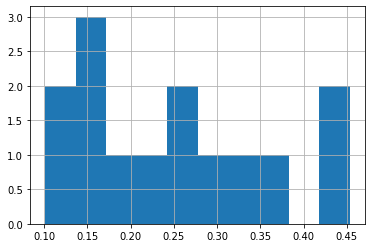

In [39]:
import pandas as pd
pd.Series(show_weights.max(axis=0)).hist()
plt.show()

In [40]:
show_weights.max(axis=0).shape

(14,)

In [41]:
subplot_size = 1
for i in range(5):
    if len(mpl_rhs) < i**2:
        subplot_size = i

In [42]:
subplot_size, len(mpl_rhs)

(4, 13)

In [43]:
show_weights[0].shape

(14,)

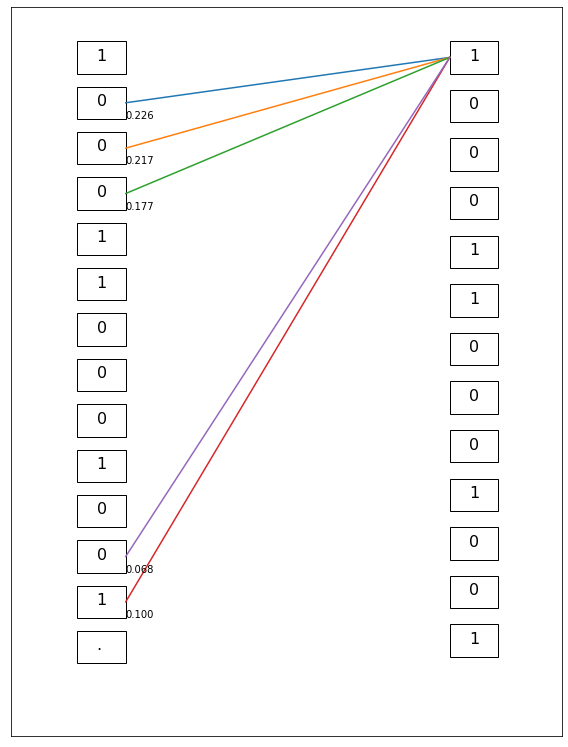

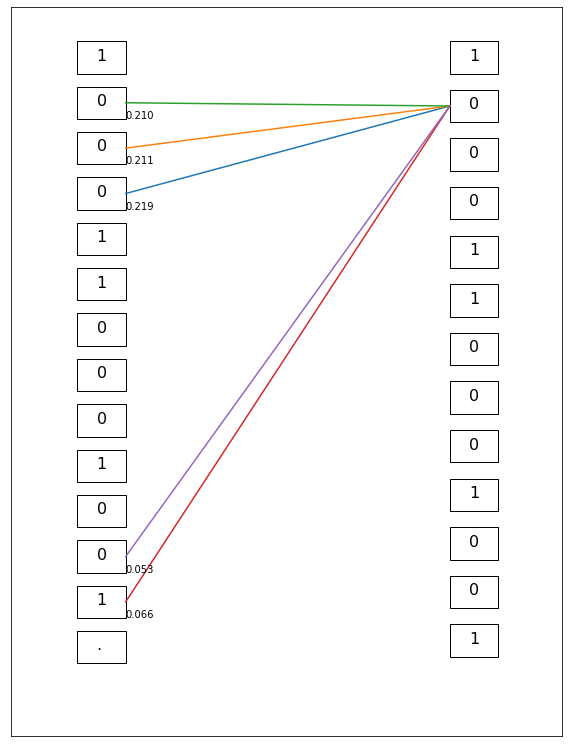

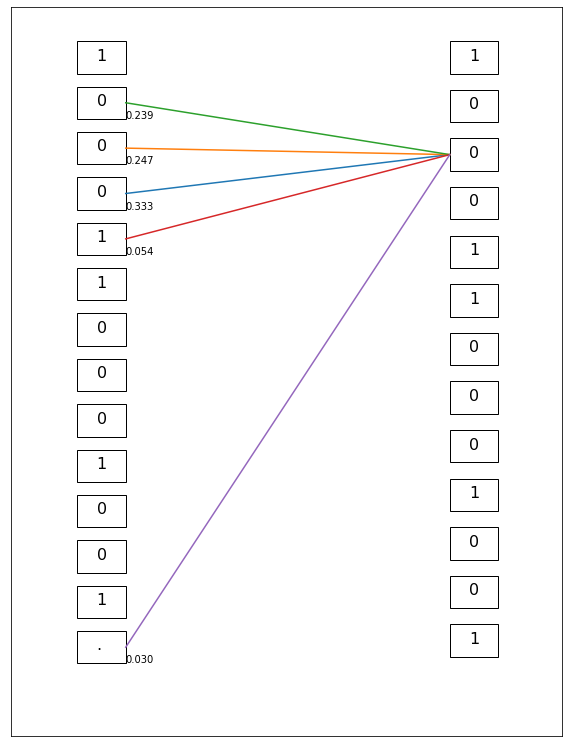

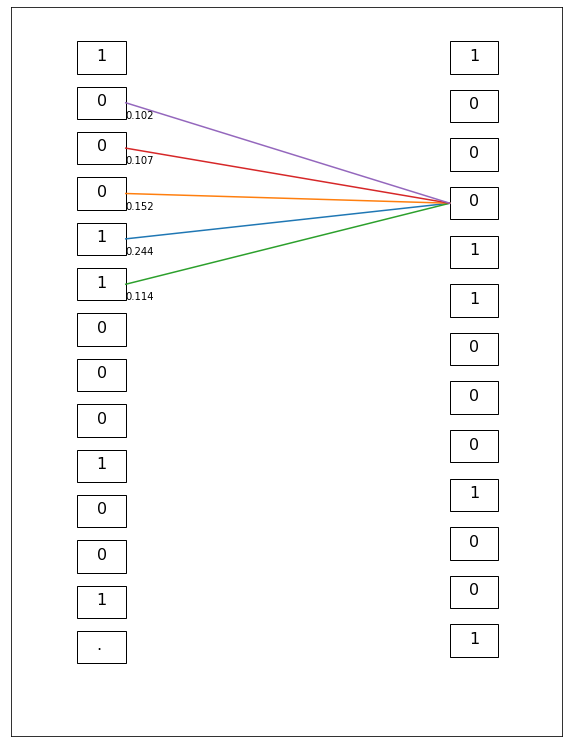

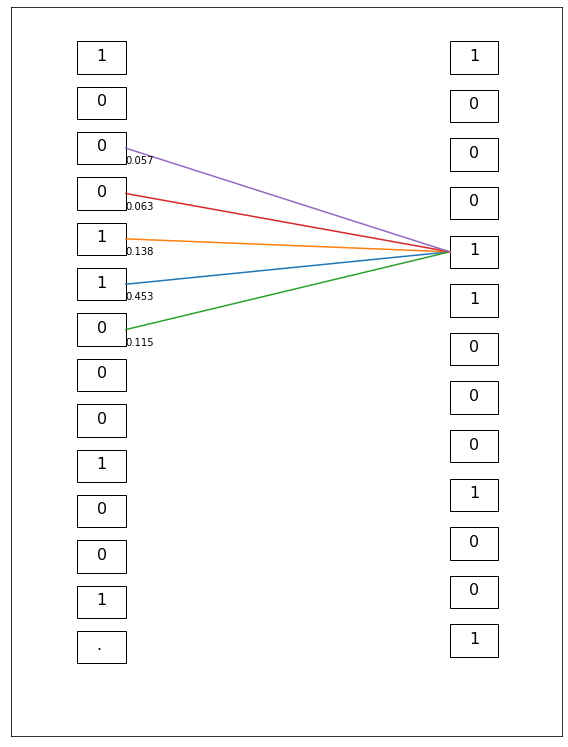

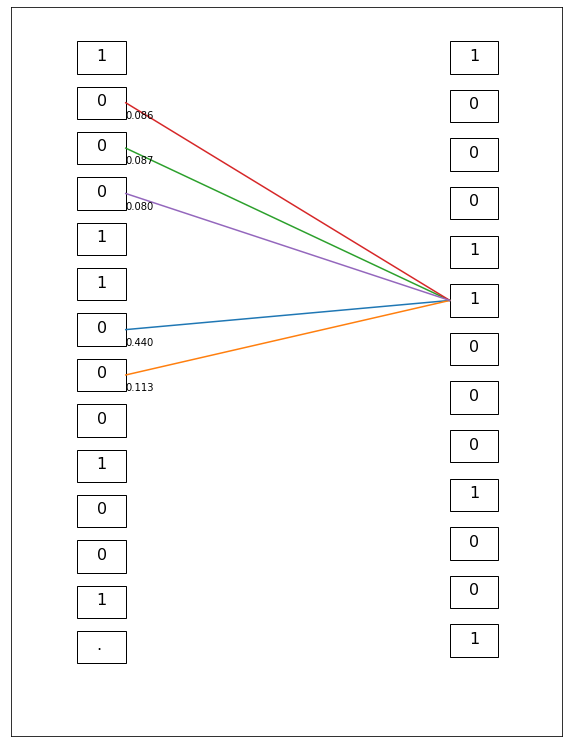

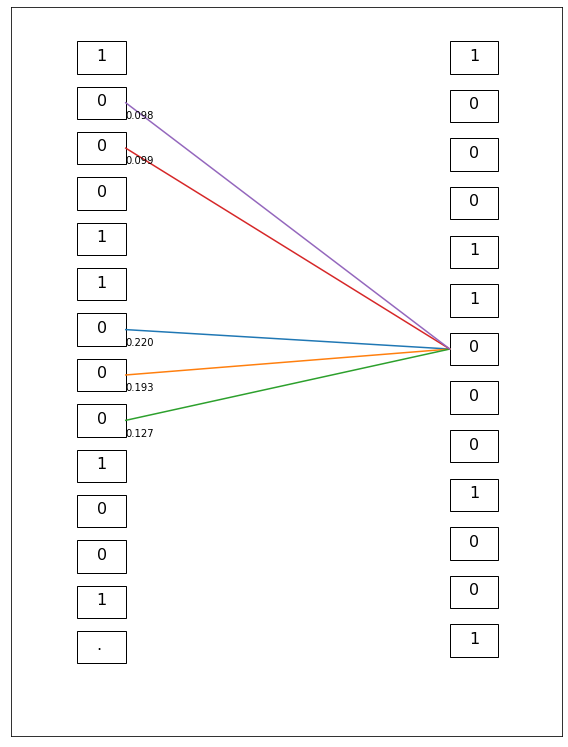

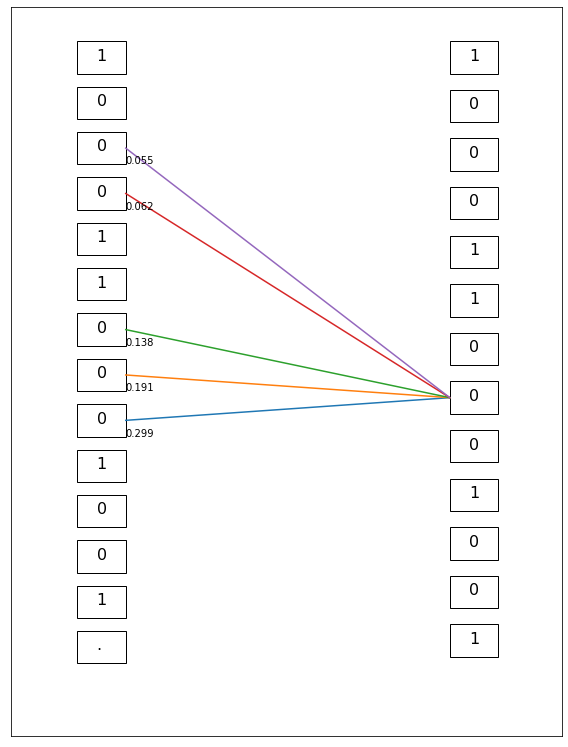

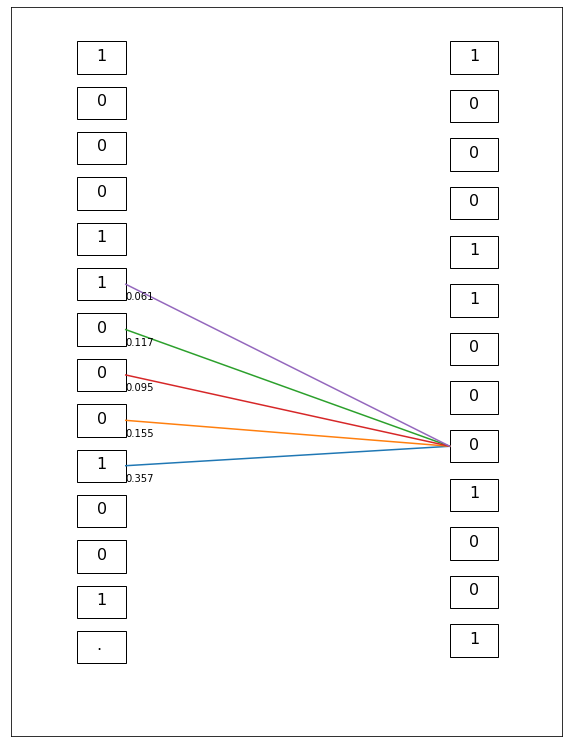

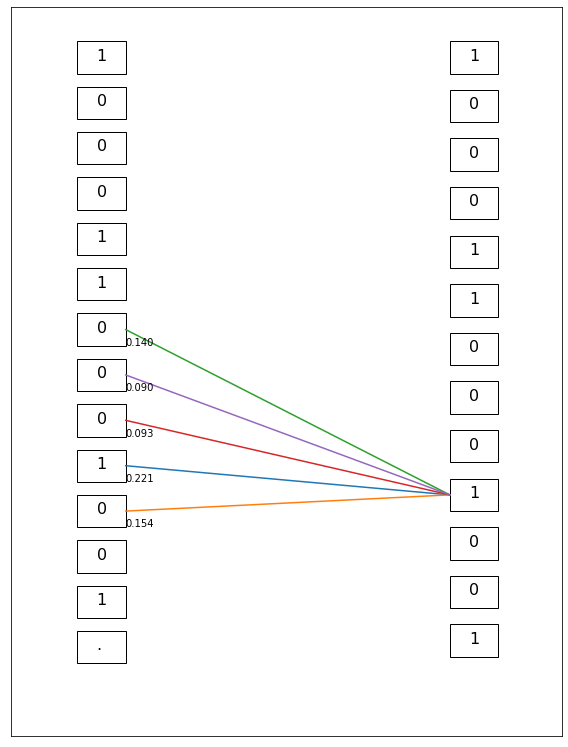

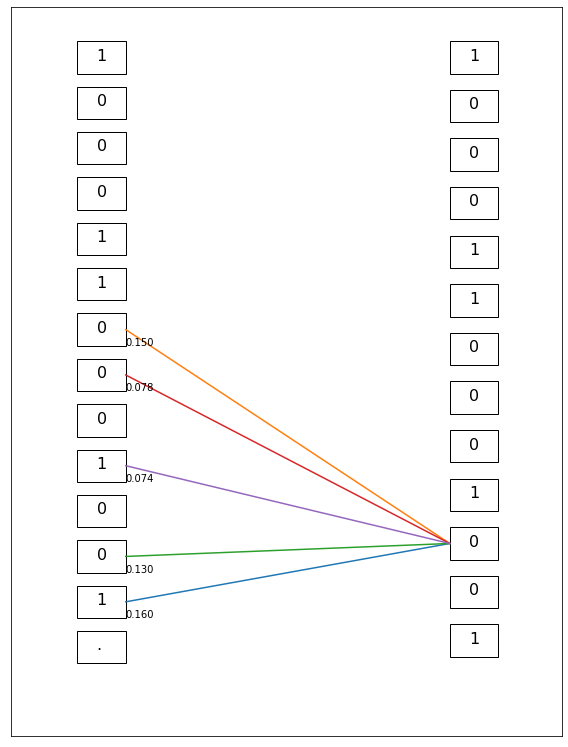

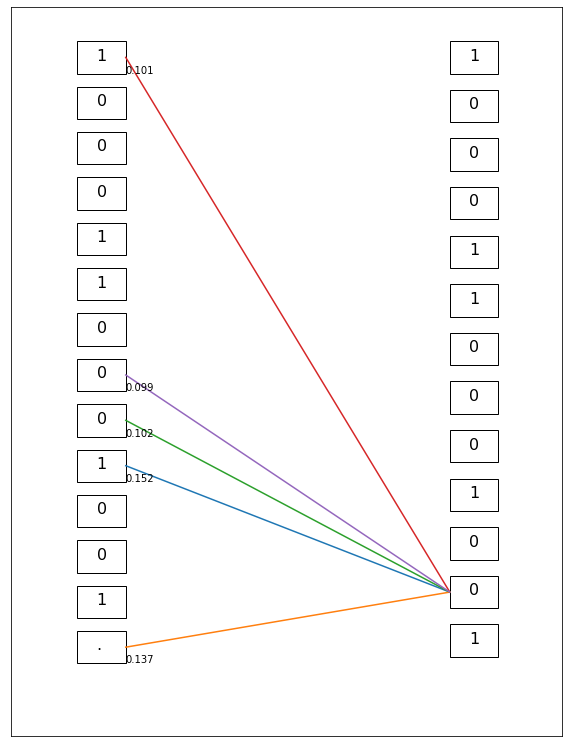

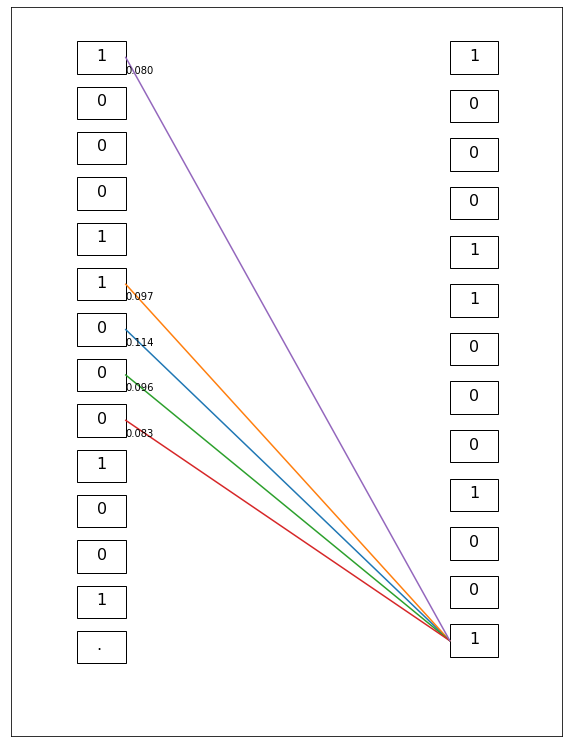

In [46]:
def draw_column(ax, x_pos, vals):
    n_boxes = len(vals)
    y_pos = v_margin
    available_height = height - 2*v_margin
    box_v_space = available_height // n_boxes
    for i in range(n_boxes):
        rect = patches.Rectangle((x_pos, y_pos), box_width, box_height, facecolor='none', edgecolor='black')
        ax.text(x_pos + box_width//2-1, y_pos + box_height//2+1, vals[i], fontsize=16)
        ax.add_patch(rect)
        y_pos += box_v_space
    
def draw_lines(ax, rhs_idx, vals, top_n, lhs_len, rhs_len):
    sorted_indicies = np.argsort(vals)[::-1]
    top_indicies = sorted_indicies[:top_n]
    
    rhs_x_loc = width - box_width - h_margin
    available_height = height - 2*v_margin
    box_v_space_rhs = available_height // rhs_len
    rhs_y_loc = v_margin + rhs_idx*box_v_space_rhs + box_height//2
    
    box_v_space_lhs = available_height // lhs_len
    for i in top_indicies:
        lhs_x_loc = box_width + h_margin
        lhs_y_loc = v_margin + i*box_v_space_lhs + box_height//2
        ax.plot((lhs_x_loc, rhs_x_loc), (lhs_y_loc, rhs_y_loc))
        ax.text(lhs_x_loc, lhs_y_loc + 5, '%.3f'%vals[i])
        
    
    
    
for i in range(show_weights.shape[0]):
    ax = plt.gca()
    fig = plt.gcf()
    ax.imshow(np.ones((height, width)), cmap='gray', vmin=0, vmax=1)
    draw_column(ax, h_margin, mpl_lhs)
    draw_column(ax, width - h_margin - box_width, mpl_rhs)
    ax.set_xticks([])
    ax.set_yticks([])
    draw_lines(ax, i, show_weights[i], 5, len(mpl_lhs), len(mpl_rhs))


    fig.set_size_inches(8,12)
    fig.tight_layout()
    plt.show()